In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
from datetime import datetime
from scipy.optimize import least_squares
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
!pwd

/home/as111/sipm-analysis


In [3]:
# data folder
path = "/scratch/gpfs/as111/results/2023-12-13"
data_spe = {}
channels = np.arange(8)
volt = 98
for ch in channels:
    data_spe[ch] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
    files = glob.glob(f"{path}/*volt_{volt}*laser_waveform_liq5.h5")
    print(files)
    for f in files:
        df = pd.read_hdf(f, key=f'{volt}/{ch}')
        data_spe[ch]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
        if data_spe[ch]['time'].shape[0]==0:
            data_spe[ch]['time'] = np.array(df['time'])
        if np.array(df['n_spe_wfs'])[0]>0:
            if data_spe[ch]['avg_spe_wf'].shape[0]==0:
                data_spe[ch]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            else:
                data_spe[ch]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
    df = None
    if data_spe[ch]['n_spe_wfs']>0:
        data_spe[ch]['avg_spe_wf'] /= data_spe[ch]['n_spe_wfs']

['/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run0_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run5_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run3_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run4_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run8_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run2_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run9_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run6_laser_waveform_liq5.h5', '/scratch/gpfs/as111/results/2023-12-13/2023-12-13_volt_98_light_laser_cond_ar_run1_laser_waveform_liq5.h5', '/scratch/gpfs/as1

ch0 98V 52299 waveforms selected
ch1 98V 81432 waveforms selected
ch2 98V 71748 waveforms selected
ch3 98V 93174 waveforms selected
ch4 98V 97203 waveforms selected
ch5 98V 80366 waveforms selected
ch6 98V 35761 waveforms selected
ch7 98V 30428 waveforms selected


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

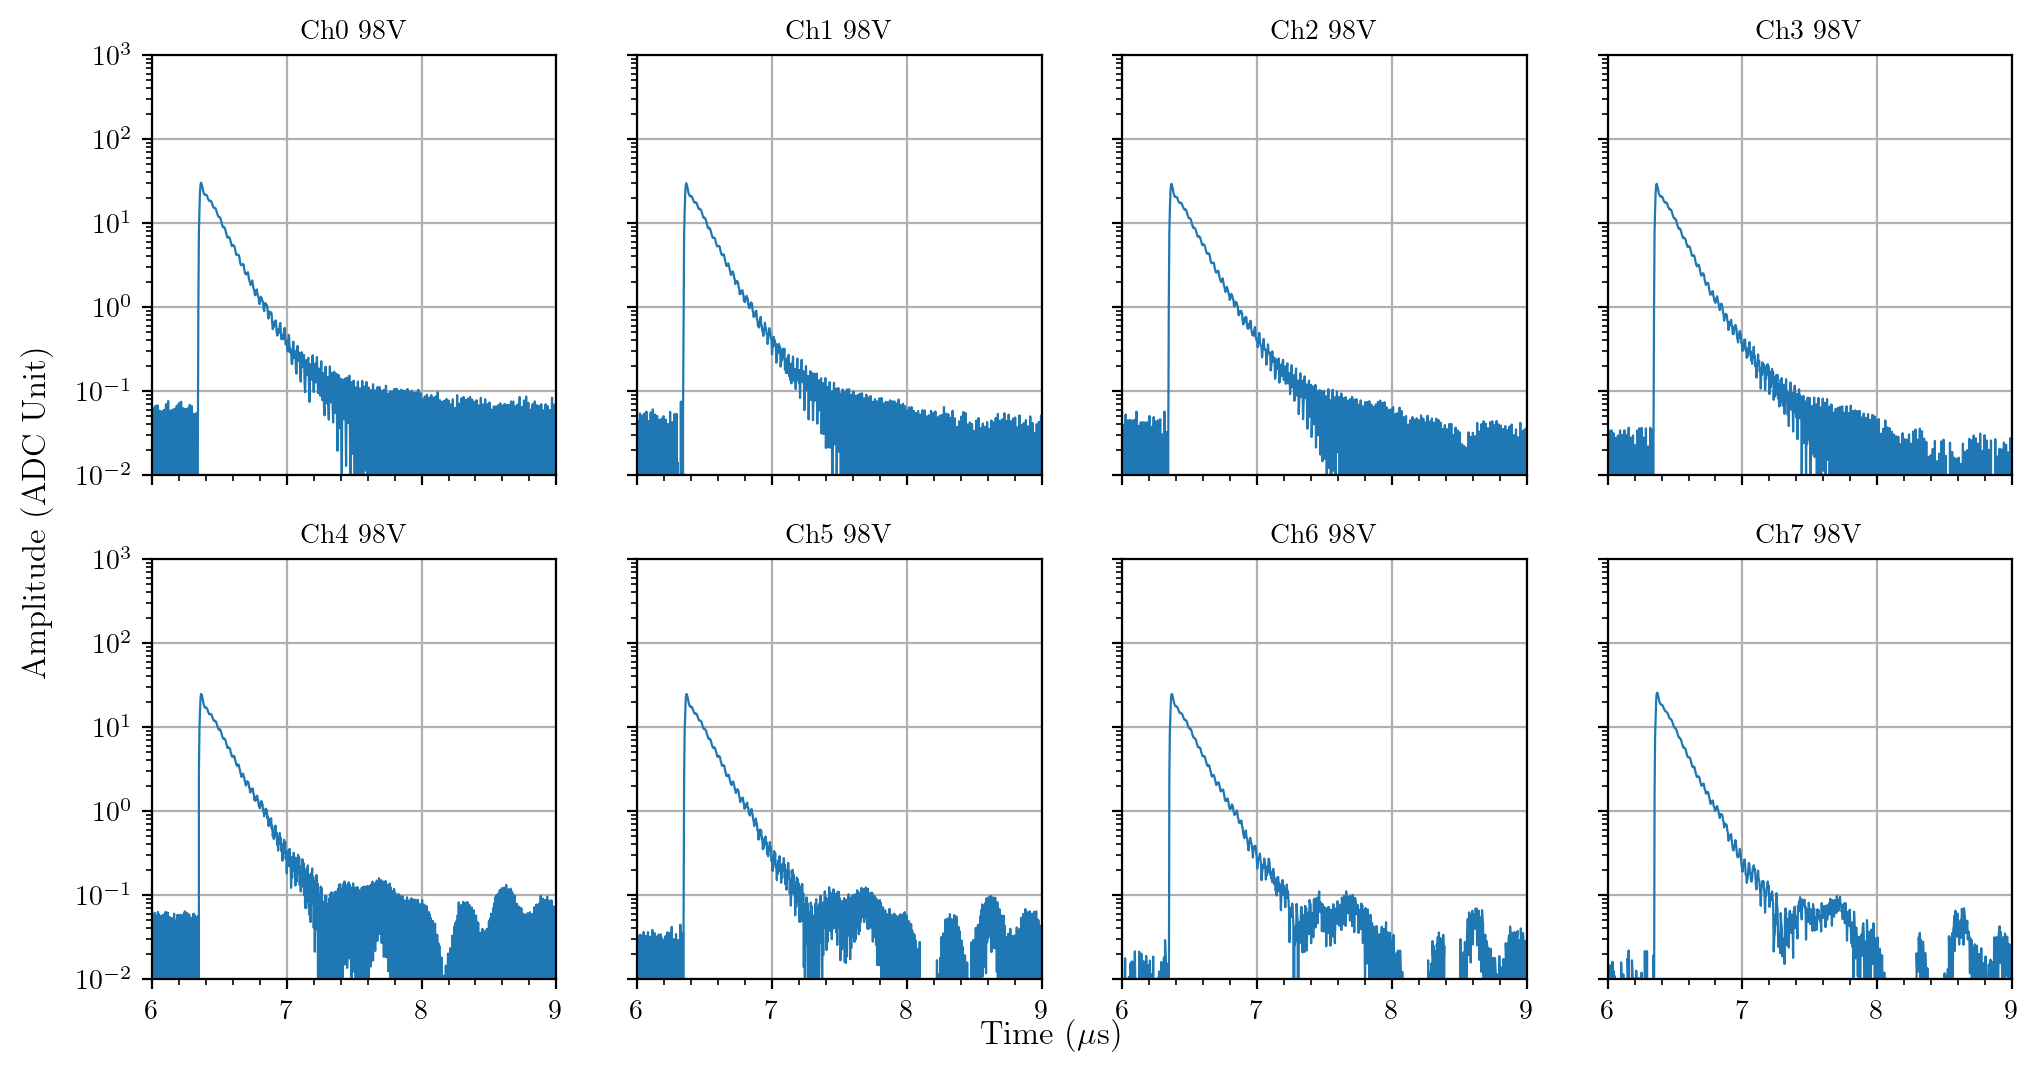

In [4]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    if data_spe[ch]['n_spe_wfs']>0:
        print(f'ch{ch} {volt}V {data_spe[ch]["n_spe_wfs"]:.0f} waveforms selected')
        axs[j//4, j%4].plot(
            data_spe[ch]['time'],
            data_spe[ch]['avg_spe_wf'],linewidth=0.8)
    axs[j//4, j%4].set_xlim(6, 9)
    axs[j//4, j%4].set_ylim(1e-2, 1e3)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'Time ($\mu$s)', y=0.05)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## FFT

In [5]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    data_spe[ch]['fft_spe_wf'] = fft(data_spe[ch]['avg_spe_wf'])
    dt = data_spe[ch]['time'][1]-data_spe[ch]['time'][0]
    t_total = dt+data_spe[ch]['time'][-1]
    n_over_2 = int(data_spe[ch]['time'].shape[0]/2)
    data_spe[ch]['frequency'] = data_spe[ch]['time']/dt/t_total
    axs[j//4, j%4].plot(
        data_spe[ch]['frequency'][:n_over_2],
        abs(data_spe[ch]['fft_spe_wf'][:n_over_2]),
        label=f'{volt}V', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right')
    axs[j//4, j%4].set_xlim(data_spe[ch]['frequency'][1], data_spe[ch]['frequency'][n_over_2])
    axs[j//4, j%4].set_ylim(1e-2, 1e4)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

# Fit: exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [6]:
def template(t, a_1, tau_1, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0)

In [7]:
# Fit SPE average waveform
for j, ch in enumerate(channels):
    pretrg = 5 #us
    err = np.std(data_spe[ch]['avg_spe_wf'][data_spe[ch]['time']<pretrg])
    fit_range = [6.2,7.5] #us
    range_arr = (data_spe[ch]['time']<fit_range[1])&(data_spe[ch]['time']>fit_range[0])
    # print(pos,ch,volt)
    # print(data_spe[pos][ch][volt]['time'][range_arr])
    # print(data_spe[pos][ch][volt]['avg_spe_wf'][range_arr])
    popt,pcov = curve_fit(
        template,
        data_spe[ch]['time'][range_arr], 
        data_spe[ch]['avg_spe_wf'][range_arr], 
        p0=[20, 0.15, 0.005, 6.35], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
    data_spe[ch]['pars'] = popt
    data_spe[ch]['cov'] = pcov
    print(popt)

[3.09978444e+01 1.44186287e-01 4.98543328e-03 6.35198728e+00]
[2.98576818e+01 1.45897283e-01 4.78143251e-03 6.35198606e+00]
[2.91092843e+01 1.49812852e-01 4.69644096e-03 6.35153502e+00]
[2.95886277e+01 1.45414900e-01 4.76844381e-03 6.35163753e+00]
[2.44756170e+01 1.46659801e-01 4.63745825e-03 6.35366751e+00]
[2.48016769e+01 1.45701012e-01 4.71951053e-03 6.35401420e+00]
[2.51048752e+01 1.45447319e-01 4.83536352e-03 6.35419334e+00]
[2.63450992e+01 1.39803756e-01 4.89159142e-03 6.35524434e+00]


# Triplet lifetime
Here the average waveforms are deconvolved channel-by-channel using their respective SPE pulse shapes.
The deconvolved waveform is given by
$$f_{deconv}(t) = \mathcal{F}^{-1}\left(\frac{\mathcal{F}(f_{original}(t))}{\mathcal{F}(f_{SiPM}(t))}\right)$$
Note that the SiPM pulse shape has to be shifted such that the trigger for it is at $t=0$.<br>

The average waveforms are selected from the events with $0.1<F_{\rm prompt}<0.5$ and $20<N_{\rm PE}<200$ ($100<N_{\rm PE}<1000$) for the top (bottom), corresponding to an energy range of $100$ keV $\lesssim E \lesssim 1000$ keV

In [8]:
S_PER_HR = 3600
# dt_getter = datetime(2024,2,14,15,0,0)
# print('The getter was turned on at', dt_getter)

dt_xe1 = datetime(2024,2,28,16,33,0)
print('Xenon injection #1 at', dt_xe1)

dt_xe2 = datetime(2024,3,6,15,0,0)
print('Xenon injection #2 at', dt_xe2)

Xenon injection #1 at 2024-02-28 16:33:00
Xenon injection #2 at 2024-03-06 15:00:00


In [9]:
# Pure LAr
# path = "/scratch/gpfs/as111/results/"
# dates = ['2024-02-16','2024-02-19','2024-02-21','2024-02-22','2024-02-23']
# files = []
# for d in dates:
#     files.extend(glob.glob(f"{path}{d}/*scintillation_waveform_liq6.h5"))
# print(files)
# print(len(files))

# Xe injection monitoring
path = "/scratch/gpfs/as111/results/"
dates = ['2024-02-28','2024-03-01','2024-03-04', # injection #1
         '2024-03-06','2024-03-08' # injection #2
        ]
files = []
for d in dates:
    files.extend(glob.glob(f"{path}{d}/*cond_monitor*scintillation_waveform_liq6.h5"))
for i,f in enumerate(files):
    files[i] = [files[i]]
print(files)
print(len(files))

[['/scratch/gpfs/as111/results/2024-02-28/2024-02-28_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run11_scintillation_waveform_liq6.h5'], ['/scratch/gpfs/as111/results/2024-02-28/2024-02-28_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run8_scintillation_waveform_liq6.h5'], ['/scratch/gpfs/as111/results/2024-02-28/2024-02-28_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run7_scintillation_waveform_liq6.h5'], ['/scratch/gpfs/as111/results/2024-02-28/2024-02-28_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run5_scintillation_waveform_liq6.h5'], ['/scratch/gpfs/as111/results/2024-02-28/2024-02-28_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run4_scintillation_waveform_liq6.h5'], ['/scratch/gpfs/as111/results/2024-02-28/2024-02-28_volt_98_light_scintillation_cond_monitor_source_co60_xenon_1_run10_scintillation_waveform_liq6.h5'], ['/scratch/gpfs/as111/results/2024-02-28/2024-02-28_volt_98_light_scintillation_cond_

In [10]:
# data folder
data_scint = {}
date_time = {}
channels = np.arange(8)
channels_nofs = [1,2,4,7] 
channels_fs = [0,3,5,6]
ch_old = [0,5,6,3,4,1,2,7] # map to channels in liq5 calibration data
volt = 98
for i,fs in enumerate(files):
    data_scint[i] = {}
    for j,f in enumerate(fs):
        df = pd.read_hdf(f, key=f'{volt}/-1')
        if j==0:
            date_time[i] = datetime(*np.array(df['start_datetime'][:6]).astype(int))
        for ch in channels:
            if j==0:
                data_scint[i][ch] = {'n_scint_wfs':0, 'avg_scint_wf':np.zeros(0), 'time':np.zeros(0)}
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            data_scint[i][ch]['n_scint_wfs'] += np.array(df['n_scint_wfs'])[0]
            if data_scint[i][ch]['time'].shape[0]==0:
                data_scint[i][ch]['time'] = np.array(df['time'].dropna())
            if data_scint[i][ch]['avg_scint_wf'].shape[0]==0:
                data_scint[i][ch]['avg_scint_wf'] = np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            else:
                data_scint[i][ch]['avg_scint_wf'] += np.array(df['avg_scint_wf'].dropna())*np.array(df['n_scint_wfs'])[0]
            df = None
            data_scint[i][ch]['avg_scint_wf'] /= data_scint[i][ch]['n_scint_wfs']
# sort according to date time
args = np.array(list(date_time.values())).argsort()
files = [files[i] for i in args]
data_scint = [data_scint[i] for i in args]
date_time = [date_time[i] for i in args]
hr_from_inject = [(dt-dt_xe1).total_seconds()/S_PER_HR for dt in date_time]

2024-03-08 21:06:32 ch0 14016 waveforms selected
2024-03-09 00:09:13 ch0 13930 waveforms selected
2024-03-09 03:11:57 ch0 13959 waveforms selected
2024-03-09 06:14:38 ch0 13927 waveforms selected
2024-03-09 09:17:19 ch0 14091 waveforms selected
2024-03-09 12:20:00 ch0 14146 waveforms selected
2024-03-09 15:22:42 ch0 13920 waveforms selected
2024-03-09 18:25:23 ch0 14271 waveforms selected
2024-03-09 21:28:06 ch0 14010 waveforms selected
2024-03-10 00:30:47 ch0 14035 waveforms selected
2024-03-10 04:33:28 ch0 13934 waveforms selected
2024-03-10 07:36:10 ch0 13862 waveforms selected
2024-03-08 21:06:32 ch1 14016 waveforms selected
2024-03-09 00:09:13 ch1 13930 waveforms selected
2024-03-09 03:11:57 ch1 13959 waveforms selected
2024-03-09 06:14:38 ch1 13927 waveforms selected
2024-03-09 09:17:19 ch1 14091 waveforms selected
2024-03-09 12:20:00 ch1 14146 waveforms selected
2024-03-09 15:22:42 ch1 13920 waveforms selected
2024-03-09 18:25:23 ch1 14271 waveforms selected
2024-03-09 21:28:06 

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

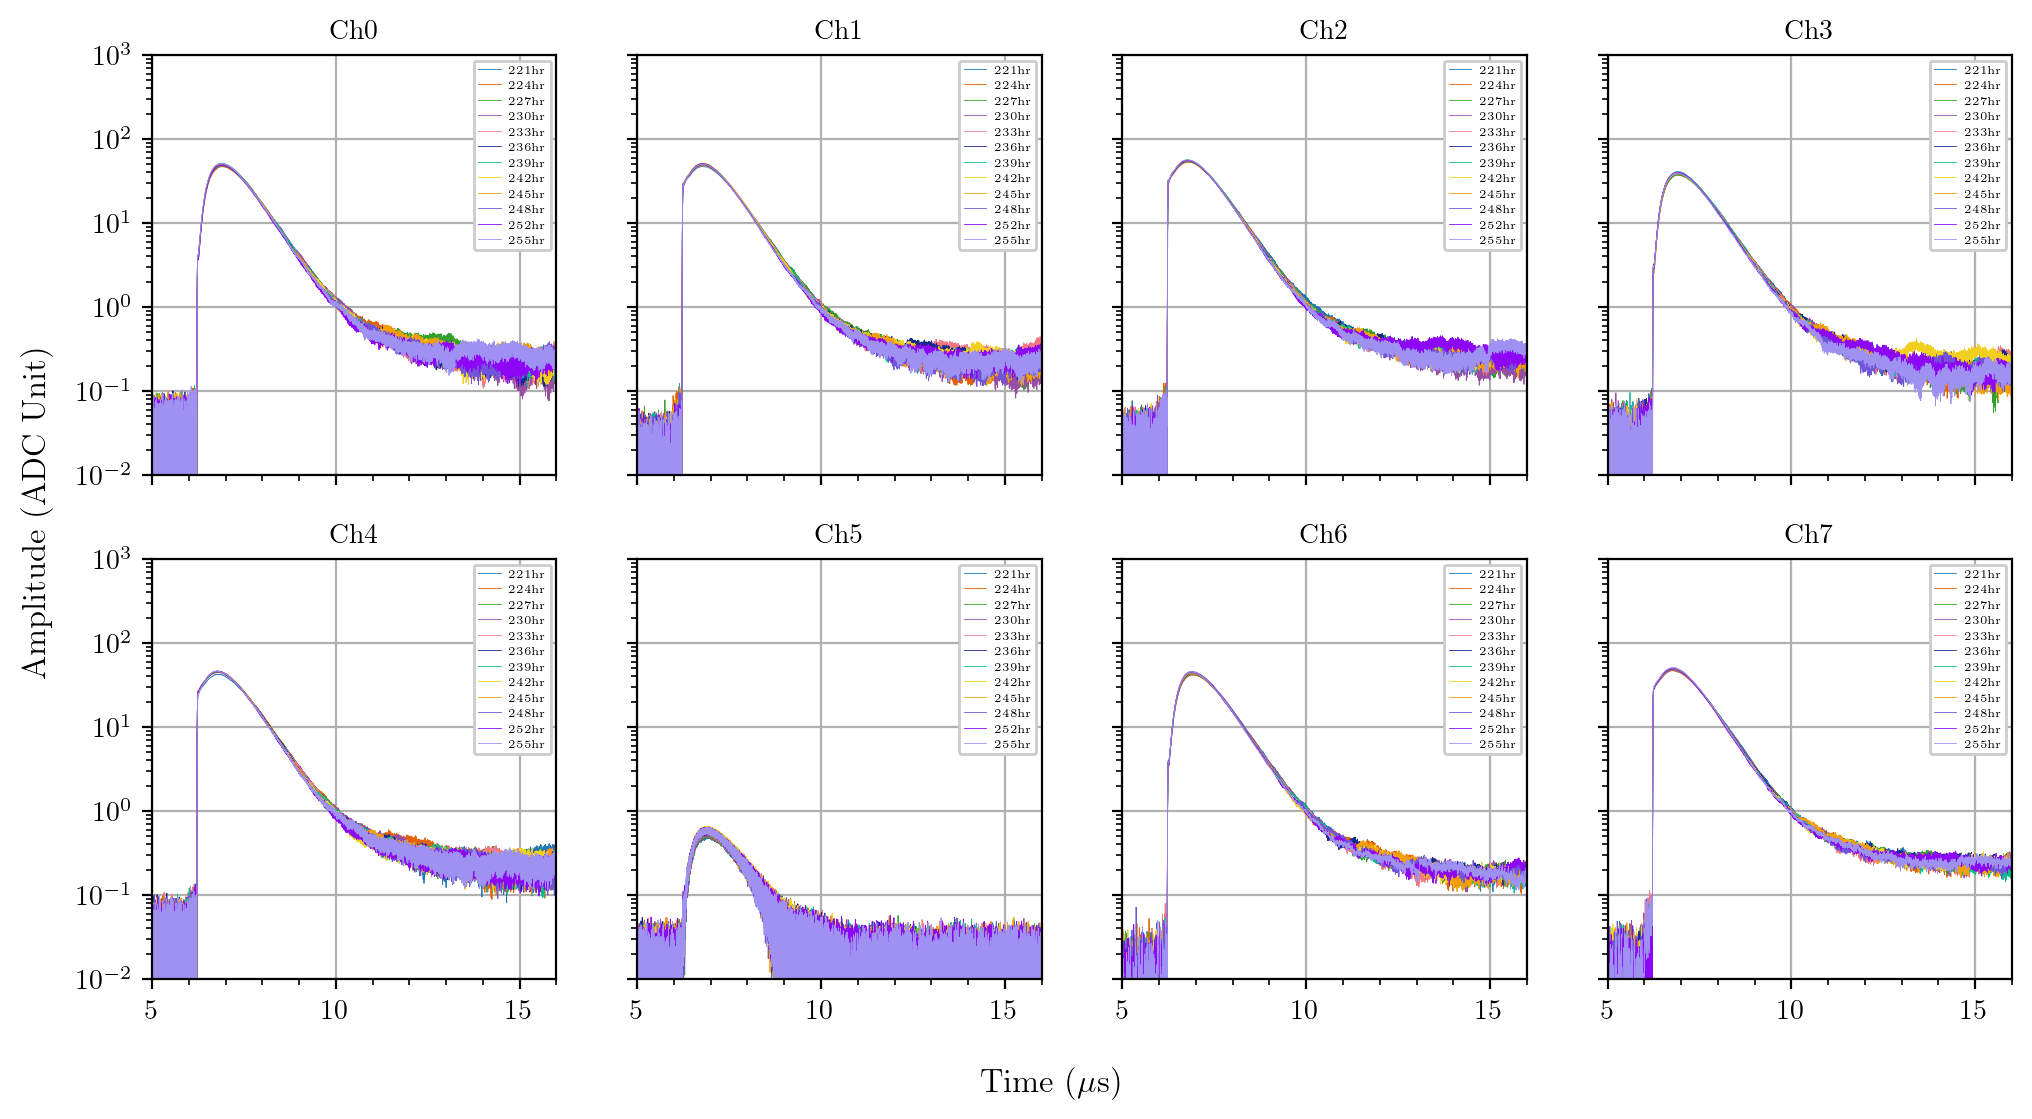

In [11]:
# Make plots for all datasets
# Average LAr scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    for k, f in enumerate(files[-12:]):
        print(f'{date_time[-12+k]} ch{ch} {data_scint[-12+k][ch]["n_scint_wfs"]:.0f} waveforms selected')
        axs[j//4, j%4].plot(
            data_scint[-12+k][ch]['time'],
            data_scint[-12+k][ch]['avg_scint_wf'],
            label=f'{hr_from_inject[-12+k]:.0f}hr', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right',fontsize=4)
    axs[j//4, j%4].set_xlim(5, 16)
    axs[j//4, j%4].set_ylim(1e-2, 1e3)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Deconvolution

In [12]:
# Deconvolution channel by channel
for i, f in enumerate(files):
    for j, ch in enumerate(channels):
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch_old[ch]]['n_spe_wfs']>0:
            dt = data_spe[ch_old[ch]]['time'][1]-data_spe[ch_old[ch]]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(data_spe[ch_old[ch]]['pars'][3]/dt))) for freq in data_spe[ch_old[ch]]['frequency']])
            data_scint[i][ch]['deconv'] = ifft(fft(data_scint[i][ch]['avg_scint_wf'])/data_spe[ch_old[ch]]['fft_spe_wf']*shift).real

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

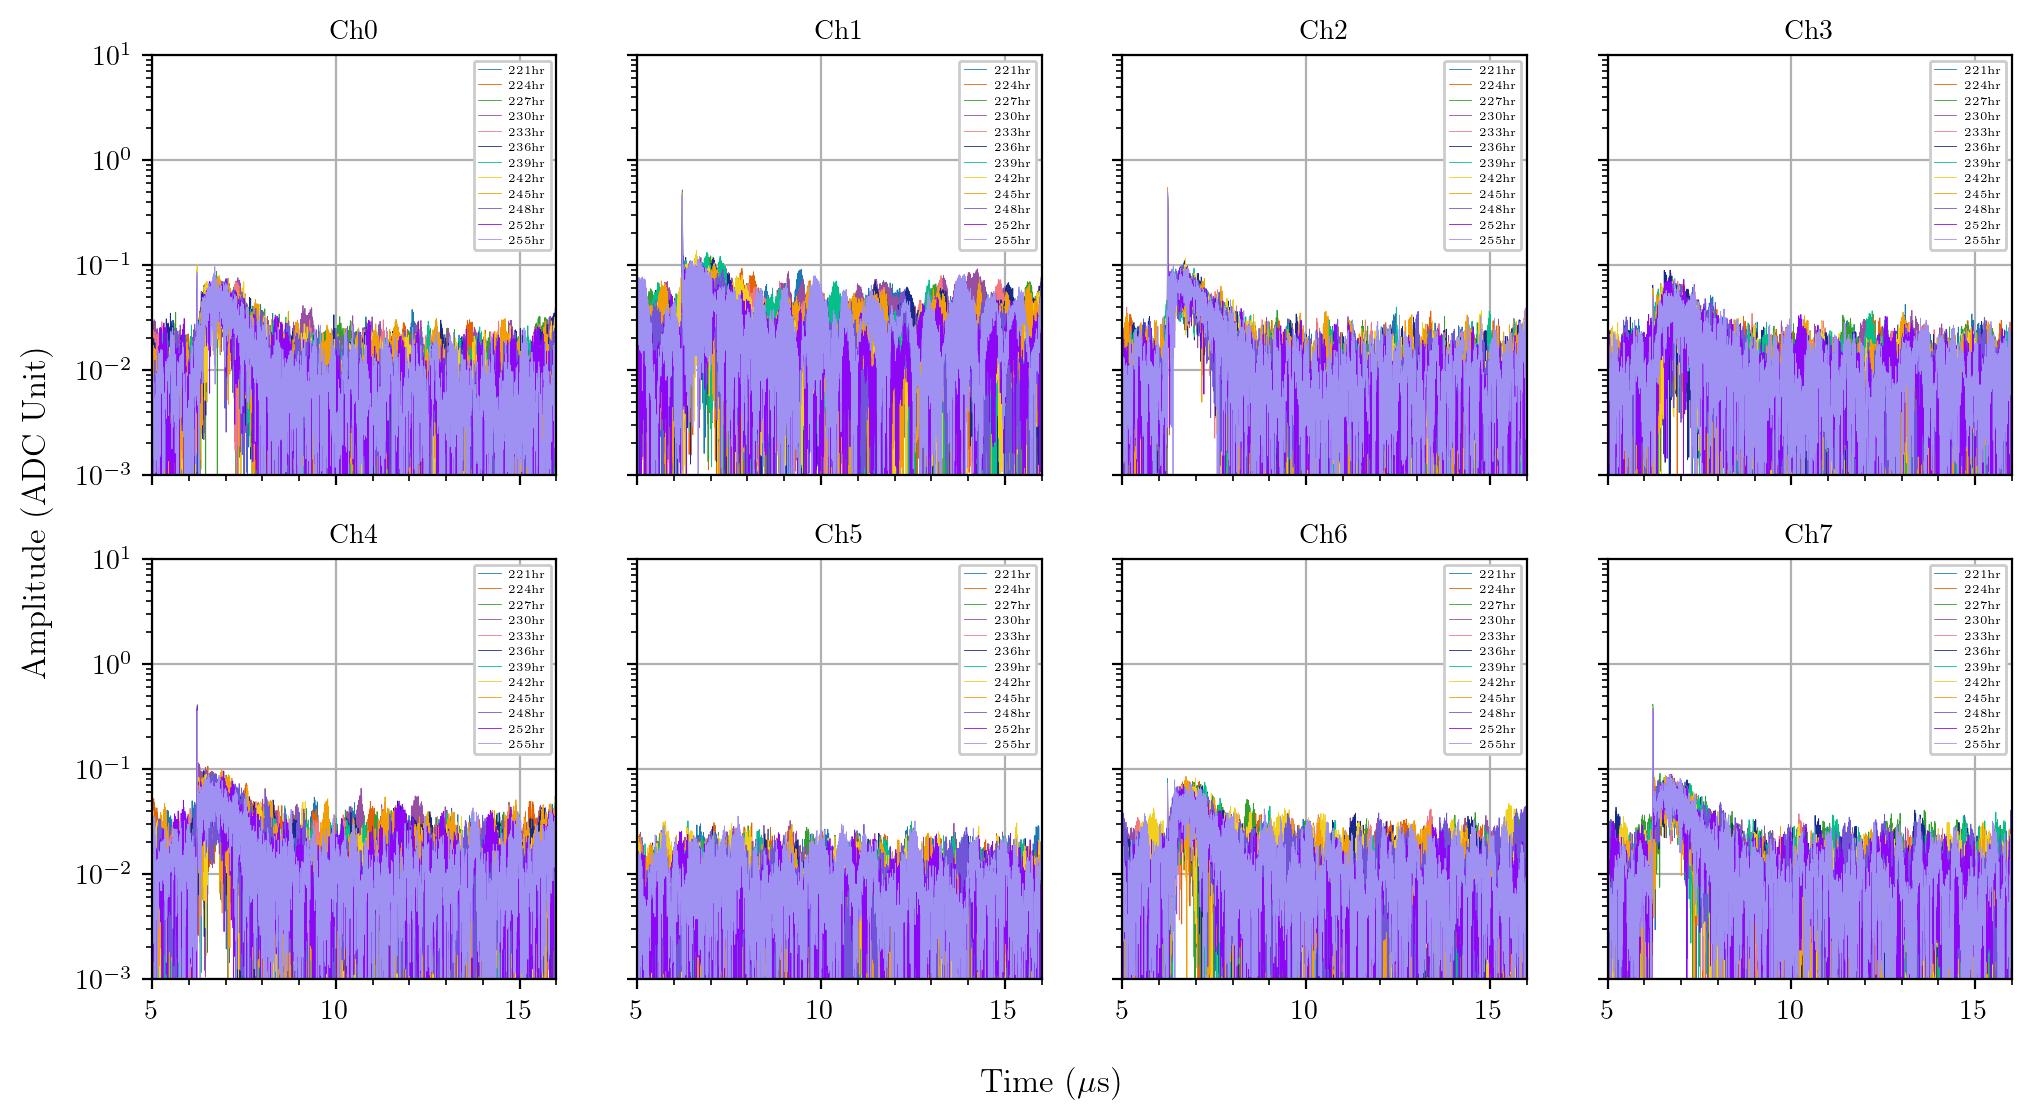

In [13]:
# Make plots for all datasets
# Deconvolved scintillation waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for j, ch in enumerate(channels):
    for k, f in enumerate(files[-12:]):
        if data_scint[-12+k][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            axs[j//4, j%4].plot(
                data_scint[-12+k][ch]['time'],
                abs(data_scint[-12+k][ch]['deconv']),
                label=f'{hr_from_inject[-12+k]:.0f}hr', color=f'C{k}', linewidth=0.3)
    axs[j//4, j%4].legend(loc='upper right', fontsize=4)
    axs[j//4, j%4].set_xlim(5, 16)
    axs[j//4, j%4].set_ylim(1e-3, 1e1)
    axs[j//4, j%4].set_yscale('log')
    axs[j//4, j%4].minorticks_on()
    axs[j//4, j%4].grid()
    axs[j//4, j%4].set_title(f'Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## Summation + Subsampling

In [14]:
def subsample(input_t,input_wf,nsub):
    ntot = int(input_t.shape[0]//nsub * nsub)
    new_t, new_wf = np.zeros(ntot//nsub), np.zeros(ntot//nsub)
    for i in range(nsub):
        new_t += input_t[i:ntot:nsub]
        new_wf += input_wf[i:ntot:nsub]
    new_t /= nsub
    new_wf /= nsub
    return new_t, new_wf

In [15]:
# summation
for i,f in enumerate(files):
    data_scint[i][-1] = {'time': data_scint[i][0]['time'], 'sum_wf_nofs': np.zeros(data_scint[i][0]['time'].shape[0]),'sum_wf_fs': np.zeros(data_scint[i][0]['time'].shape[0])}
    for ch in channels_nofs:    
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_nofs'] += data_scint[i][ch]['deconv']
    for ch in channels_fs:
        if data_scint[i][ch]['n_scint_wfs']>0 and data_spe[ch]['n_spe_wfs']>0:
            data_scint[i][-1]['sum_wf_fs'] += data_scint[i][ch]['deconv']

In [16]:
# subsampling
nsub = 4
for i,f in enumerate(files):
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_nofs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_nofs'],nsub)
    data_scint[i][-1]['time_sub'], data_scint[i][-1]['sum_wf_sub_fs'] = subsample(data_scint[i][-1]['time'],data_scint[i][-1]['sum_wf_fs'],nsub)

In [17]:
# Make plots for all datasets
# Summed scintillation waveform
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
nofs_total_pe = []
fs_total_pe = []
for i, f in enumerate(files):
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_nofs']),
                linewidth=0.3,label='No FS')
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time_sub'],
                abs(data_scint[i][-1]['sum_wf_sub_fs']),
                linewidth=0.3, label='FS')
    axs[i//5, i%5].set_xlim(1, 16)
    axs[i//5, i%5].set_ylim(1e-3, 1e1)
    axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
    axs[i//5, i%5].legend(loc='upper right',fontsize=5)
    nofs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_nofs'])*nsub)
    fs_total_pe.append(np.sum(data_scint[i][-1]['sum_wf_sub_fs'])*nsub)
fig.supxlabel(r'Time ($\mu$s)', y=0.06)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.04)
nofs_total_pe = np.array(nofs_total_pe)
fs_total_pe = np.array(fs_total_pe)

## Fitting

In [18]:
# def template2(t, a_1, tau_1, a_2, tau_2, sigma, t0):
#         return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [19]:
def template3(t,a,tau):
    return a*np.exp(-t/tau)

In [20]:
class LArXePulseShape():
    def __init__(self, xe_pulse, t_trig):
        """_summary_

        Args:
            xe_pulse (tuple): xe_pulse = [time_array, amplitude_array] for xenon-only pulse
        """
        self.t_arr = xe_pulse[0]
        self.xe_pulse_y = xe_pulse[1]
        self.t_trig = t_trig

    def get_pulse_model(self, a, tau, a_xe=1.33):
        pulse_model = a/tau*0.004*np.exp(-(self.t_arr-self.t_trig)/tau) + a_xe*self.xe_pulse_y # sample interval = 0.004us
        return pulse_model
        
    def fit_to_data(self, data_y, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            a, tau, a_xe = x[0], x[1], x[2]
            ar_xe_pulse = args
            ans = (ar_xe_pulse-self.get_pulse_model(a, tau, a_xe))
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (self.t_arr<fit_range[1]) & (self.t_arr>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data_y,bounds=(0,np.inf))
        cov = np.linalg.inv(res.jac.T@res.jac)
        return res.x, cov
        

In [21]:
# Fit SPE average waveform
data_sub = {}
t_trig = 6.2
for i,f in enumerate(files):
    if data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        pretrg = 5 #us
        # simple exponential fit to windowless
        # fit_range = [7,10] #us
        # windowed + simple exponential fit to windowless
        fit_range = [6.5,10] #us
        err = np.std(data_scint[i][-1]['sum_wf_sub_nofs'][data_scint[i][-1]['time_sub']<pretrg])
        
        # simple exponential fit to windowless
        # range_arr = (data_scint[i][-1]['time_sub']<fit_range[1]) & (data_scint[i][-1]['time_sub']>fit_range[0])
        # popt,pcov = curve_fit(
        #     template3,
        #     data_scint[i][-1]['time_sub'][range_arr], 
        #     data_scint[i][-1]['sum_wf_sub_nofs'][range_arr], 
        #     p0=[100,1], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        
        # windowed + simple exponential fit to windowless
        ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'],data_scint[i][-1]['sum_wf_sub_fs']/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub), t_trig=t_trig)
        popt, pcov = ar_xe_pulse_fit.fit_to_data(data_scint[i][-1]['sum_wf_sub_nofs'],sigma=err*np.ones_like(data_scint[i][-1]['time_sub']),x0=[40,1.4,40],fit_range=fit_range)
        
        data_scint[i][-1]['pars'] = popt
        data_scint[i][-1]['cov'] = pcov
        data_scint[i][-1]['pars_err'] = np.array([func.error_distance(df=3, sigma=1)*pcov[j,j]**0.5 for j in range(len(popt))])
        data_scint[i][-1]['fit_range'] = fit_range
        
        # windowed + simple exponential fit to windowless
        print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us A_Xe = {popt[2]:.3f}+/-{data_scint[i][-1]["pars_err"][2]:.3f}')

        # simple exponential fit to windowless
        # print(f'{date_time[i]} A={popt[0]:.2f}+/-{data_scint[i][-1]["pars_err"][0]:.2f} tau={popt[1]:.3f}+/-{data_scint[i][-1]["pars_err"][1]:.3f}us')
        

2024-02-28 16:45:24 A=63.17+/-0.46 tau=1.479+/-0.018us A_Xe = 0.008+/-0.110
2024-02-28 19:48:05 A=63.56+/-0.48 tau=1.670+/-0.023us A_Xe = 0.000+/-0.001
2024-02-28 22:50:46 A=69.83+/-1.05 tau=2.047+/-0.045us A_Xe = 0.614+/-0.763
2024-02-29 01:53:29 A=78.65+/-2.58 tau=2.391+/-0.076us A_Xe = 0.003+/-2.085
2024-02-29 04:56:11 A=84.61+/-3.49 tau=2.544+/-0.085us A_Xe = 0.000+/-2.655
2024-02-29 07:58:51 A=80.53+/-3.81 tau=2.457+/-0.085us A_Xe = 7.184+/-2.886
2024-02-29 11:01:32 A=77.91+/-3.72 tau=2.318+/-0.076us A_Xe = 12.366+/-2.853
2024-02-29 14:04:12 A=72.67+/-3.31 tau=2.153+/-0.064us A_Xe = 17.286+/-2.590
2024-02-29 17:06:54 A=67.53+/-2.96 tau=2.010+/-0.056us A_Xe = 20.998+/-2.350
2024-02-29 20:09:36 A=58.06+/-2.93 tau=1.809+/-0.059us A_Xe = 28.725+/-2.405
2024-02-29 23:12:18 A=57.84+/-2.52 tau=1.752+/-0.048us A_Xe = 28.825+/-2.059
2024-03-01 02:15:00 A=54.87+/-2.44 tau=1.668+/-0.045us A_Xe = 31.530+/-2.010
2024-03-01 12:35:43 A=46.72+/-2.03 tau=1.453+/-0.038us A_Xe = 37.540+/-1.710
2024-

In [22]:
# Make plots for all datasets
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
for i, f in enumerate(files):
    if data_scint[i][-1]['sum_wf_nofs'].shape[0]>0:
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'],
            data_scint[i][-1]['sum_wf_sub_nofs'],
            label=f'data', color='b', linewidth=0.3)
        mask = (data_scint[i][-1]['time_sub']>data_scint[i][-1]['fit_range'][0]) & (data_scint[i][-1]['time_sub']<data_scint[i][-1]['fit_range'][1])
        
        # simple exponential fit to windowless
        # axs[i//5, i%5].plot(
        #     data_scint[i][-1]['time_sub'][mask],
        #     template3(data_scint[i][-1]['time_sub'][mask], *data_scint[i][-1]['pars']),
        #     label=r'fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='r', linestyle='--', linewidth=1)
        
        # windowed + simple exponential fit to windowless
        ar_xe_pulse_fit = LArXePulseShape((data_scint[i][-1]['time_sub'][mask],data_scint[i][-1]['sum_wf_sub_fs'][mask]/np.sum(data_scint[i][-1]['sum_wf_sub_fs'])/nsub),t_trig=t_trig)
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'][mask],
            ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars']),
            label=r'fit $\tau=${:.3f} $\mu $s'.format(data_scint[i][-1]['pars'][1]), color='r', linestyle='--', linewidth=1)
        axs[i//5, i%5].plot(
            data_scint[i][-1]['time_sub'][mask],
            ar_xe_pulse_fit.get_pulse_model(*data_scint[i][-1]['pars'][:-1],0),
            label=r'Ar component', color='g', linestyle='--', linewidth=1)
        
        axs[i//5, i%5].legend(loc='upper right',ncol=1)
        axs[i//5, i%5].set_xlim(2, 16)
        axs[i//5, i%5].set_ylim(1e-3, 1e2)
        axs[i//5, i%5].set_yscale('log')
        axs[i//5, i%5].minorticks_on()
        axs[i//5, i%5].grid()
        axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
fig.supxlabel(r'Time ($\mu$s)', y=0.1)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

# Triplet lifetime evolution

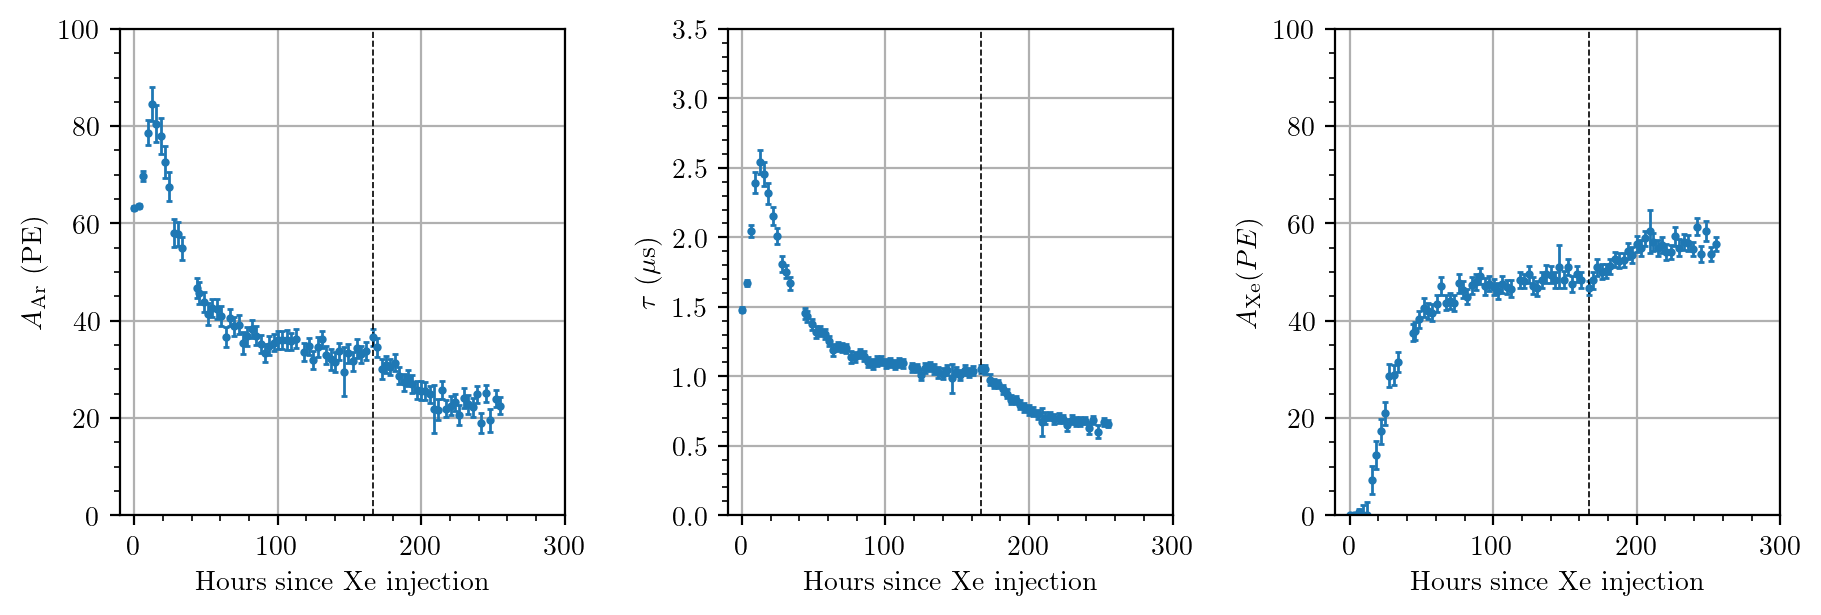

In [23]:
fig, axs = plt.subplots(1, 3, sharex=False, sharey=False)
fig.set_size_inches(9, 3)
fig.tight_layout(h_pad=3, w_pad=3)

ylabels = [r'$A_{\rm Ar}$ (PE)', r'$\tau$ ($\mu$s)', r'$A_{\rm Xe} (PE)$']
ylims = [(0,100),(0,3.5),(0,100)]

for i in range(3):
    axs[i].errorbar(
        hr_from_inject,
        [data_scint[j][-1]['pars'][i] for j in range(len(files))],
        yerr=[func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][i,i]) for j in range(len(files))],
        label=f'98V', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
    )
    axs[i].plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims[i],'k--',linewidth=0.6)
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_ylim(*ylims[i])
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_xlim(-10,300)
    axs[i].set_xlabel('Hours since Xe injection')

In [39]:
ylims = (-0,1.5)
plt.scatter(
    hr_from_inject,
	nofs_total_pe/nofs_total_pe[0],
	label='no FS', s=1
)
plt.scatter(
    hr_from_inject,
	fs_total_pe/nofs_total_pe[0],
	label='FS', s=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.xlim(-10,300)
plt.minorticks_on()
plt.ylabel(r'Relative Waveform Integral')
plt.xlabel('Hours since Xe injection')
plt.legend()

Text(0.5, 0, 'Hours since Xe injection')

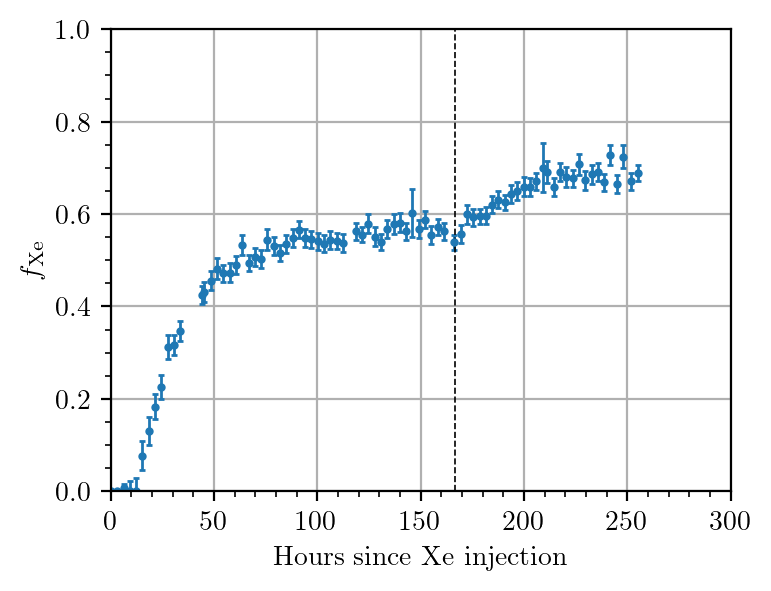

In [24]:
ylims = (0,1)
plt.errorbar(
    hr_from_inject,
	np.array([data_scint[j][-1]['pars'][i] for j in range(len(files))])/nofs_total_pe,
	yerr=np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][i,i]) for j in range(len(files))])/nofs_total_pe,
	linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1
)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.grid()
plt.ylim(*ylims)
plt.minorticks_on()
plt.ylabel(r'$f_{\rm Xe}$')
plt.xlabel('Hours since Xe injection')

In [25]:
tau = np.array([data_scint[j][-1]['pars'][1] for j in range(len(files))])
tau_err = np.array([func.error_distance(df=3, sigma=1)*np.sqrt(data_scint[j][-1]['cov'][1,1]) for j in range(len(files))])
tau0 = data_scint[0][-1]['pars'][1]
tau0_err = func.error_distance(df=2, sigma=1)*np.sqrt(data_scint[0][-1]['cov'][1,1])
n_sigma_v = 1/tau - 1/tau0
n_sigma_v_err = ((tau_err/tau**2)**2 + (tau0_err/tau0**2)**2)**0.5
plt.errorbar(
        hr_from_inject,
        n_sigma_v,
        yerr=n_sigma_v_err,
        linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,[-0.5,1.5],'k--',linewidth=0.6)
plt.ylabel(r'$\tau^{-1}-\tau_0^{-1}$ ($\rm \mu s^{-1}$)')
plt.xlabel('Hours since Xe injection')
plt.xlim(-10,300)
plt.ylim(-0.5,1.5)
plt.grid()
plt.minorticks_on()

# Rise time

In [26]:
from numpy import interp

In [27]:
# Make plots for all datasets
# Summed scintillation waveform
t_rise = {'fs':[], 'nofs':[]}
nrows = (len(files)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(15, 3*nrows)
for i, f in enumerate(files):
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time'],
                abs(data_scint[i][-1]['sum_wf_nofs']),
                linewidth=1, label='No FS', color='C0')
    axs[i//5, i%5].plot(
                data_scint[i][-1]['time'],
                abs(data_scint[i][-1]['sum_wf_fs']),
                linewidth=1, label='FS', color='C1')
    axs[i//5, i%5].set_xlim(6.2, 6.3)
    axs[i//5, i%5].set_ylim(-0.2, 6)
    # axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    axs[i//5, i%5].set_title(f'{hr_from_inject[i]:.0f}hr')
    axs[i//5, i%5].legend(loc='upper right',fontsize=5)
    for k in t_rise.keys():
        height = np.max(data_scint[i][-1][f'sum_wf_{k}'])
        sample_max = np.argmax(data_scint[i][-1][f'sum_wf_{k}'])
        t10 = interp(
            0.1*height,
            data_scint[i][-1][f'sum_wf_{k}'][sample_max-3:sample_max+1],
            data_scint[i][-1]['time'][sample_max-3:sample_max+1]
        )
        t90 = interp(
            0.9*height,
            data_scint[i][-1][f'sum_wf_{k}'][sample_max-3:sample_max+1],
            data_scint[i][-1]['time'][sample_max-3:sample_max+1]
        )
        t_rise[k].append(t90-t10)
        axs[i//5, i%5].scatter([t10,t90],[0.1*height, 0.9*height], s=6, color='C0' if k=='nofs' else 'C1', marker='>')
fig.supxlabel(r'Time ($\mu$s)', y=0.06)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.04)

Text(0.04, 0.5, 'Amplitude (ADC Unit)')

In [40]:
xlims = (-10,300)
ylims = (0,20)
plt.scatter(hr_from_inject, np.array(t_rise['nofs'])*1e3, label='no FS', s=1)
plt.scatter(hr_from_inject, np.array(t_rise['fs'])*1e3, label='FS', s=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,ylims,'k--',linewidth=0.6)
plt.plot(xlims,[4]*2,'r--',linewidth=0.4)
plt.ylim(*ylims)
plt.xlim(*xlims)
plt.ylabel(r'Rise time $t_{0.9}-t_{0.1}$ ($\rm ns$)')
plt.xlabel('Hours since Xe injection')
plt.grid()
plt.minorticks_on()
plt.legend()